# Self-supervised vs. Supervised Learning

Supervised learning on graphs: Labels come from external sources 
    e.g. predict rating of an interaction n
    
Self-supervised learning on graphs: Signals come from graphs themselves 
    e.g. link prediction: predict if two nodes are connected , only 
    rely on graph data structure 
    
How we construct the graph?
    In the supervised learning setting, we want to keep every interaction (good or bad) between nodes, and have teh model learn these interaction since we have explicit labels. So we are going to set rating_threshold to 1.
    
What loss function do we use? 
    We plan to use RMSE because it's supervised learning.
    

In [326]:
%load_ext autoreload
%autoreload 2

# imports 

In [301]:
# import modules 
import random 
from tqdm.notebook import tqdm 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn import model_selection, metrics, preprocessing 
import copy 

import torch
from torch import nn, optim, Tensor 

from torch_sparse import SparseTensor, matmul

from collections import defaultdict 

from torch_geometric.utils import structured_negative_sampling 
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm 
from torch_geometric.nn.conv import MessagePassing 
from torch_geometric.typing import Adj
import torch.nn.functional as F

# Load Dataset

In [302]:
# download dataset 
# https://grouplens.org/datasets/movielens 
# "small: 100,000 ratings andd 3,600 tag applications appliedd to 9,000 movies by 600 users, last updated on 9/2018"
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [303]:
rating_df = pd.read_csv(rating_path)

lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [304]:
print(rating_df.userId.max())
print(rating_df.movieId.max())


609
9723


In [305]:
# load edges between users and movies 
#  
# args:
#     path (str): path to csv file 
#     src_index_col (str): column name of users
#     src_mapping (dict): mapping between row number and user id
#     dst_index_col (str): column name of items 
#     dst_mapping (dict): mapping between row numbers andd item id 
#     link_index_col (str): column name of user item interaction
#     rating_thresholdd (int, optional): Threshold to determine positivity of edge, Defaults to 4
#
# returns:
#     torch.Tensor: 2 by N matrix containing the node ids of N user-item edges
def load_edge_csv(df, 
                 src_index_col,
                 dst_index_col,
                 link_index_col,
                 rating_threshold=3.5):
    
    edge_index = None 
    src = [user_id for user_id in df['userId']]
    
    num_users = len(df['userId'].unique())
    
    dst = [(movie_id) for movie_id in df['movieId']]
    
    link_vals = df[link_index_col].values 
    
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold
    
    edge_values = []
    
    edge_index = [[],[]]
    
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
            edge_values.append(link_vals[i])
    
    # edge_values is the label we will use for compute training loss 
    return edge_index, edge_values

In [306]:
edge_index, edge_values = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=1  # need to use threshold=1 so the model can learn based on RMSE
)

In [307]:
# convert to tensor 
# we use LongTensor here because the .propagate() method in the model either LongTensor or SparseTensor 

edge_index = torch.LongTensor(edge_index)
edge_values = torch.tensor(edge_values)

print(edge_index)
print(edge_index.size())

print(edge_values)
print(edge_values.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9444, 9445, 9485]])
torch.Size([2, 99466])
tensor([4., 4., 4.,  ..., 5., 5., 3.], dtype=torch.float64)
torch.Size([99466])


In [308]:
# split the edges of the graph using a 80/10/10 train/validation/test split
# num_users, num_movies = len(user_mapping), len(movie_mapping)

num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

print(f"num_users {num_users}, num_movies {num_movies}")

num_users 610, num_movies 9724


In [383]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index, input_edge_values):
    R = torch.zeros((num_users, num_movies))
    
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = input_edge_values[i]  # assign actual edge value to Interaction Matrix 
   
    R_transpose = torch.transpose(R, 0, 1)
    
    # create adj_matrix 
    adj_mat = torch.zeros((num_users + num_movies, num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo_indices = adj_mat_coo.indices()
    adj_mat_coo_values = adj_mat_coo.values()
    return adj_mat_coo_indices, adj_mat_coo_values

In [384]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index, input_edge_values):
    
    print(num_users, num_movies)
#    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
#                                          col=input_edge_index[1],
#                                          value = input_edge_values,
#
# below line throws error, need to fix, borrow from section 2 for now
#
#                                          sparse_sizes=((num_users + num_movies), num_users + num_movies))
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0],
                                          col=input_edge_index[1],
                                          sparse_sizes=((num_users + num_movies), num_users+num_movies))


    

    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    r_mat_edge_values = interact_mat.to_sparse_coo().values()
    
    
    return r_mat_edge_index, r_mat_edge_values



In [480]:
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                            test_size=0.2,
                                            random_state=1)

val_indices, test_indices = train_test_split(test_indices,
                                             test_size=0.5,
                                             random_state=1)

In [481]:
train_edge_index = edge_index[:, train_indices]
train_edge_value = edge_values[train_indices]

val_edge_index = edge_index[:, val_indices]
val_edge_value = edge_values[val_indices]

test_edge_index = edge_index[:, test_indices]
test_edge_value = edge_values[test_indices]

In [482]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

print(test_edge_value)
print(test_edge_value.size())

num_users 610, num_movies 9724, num_interactions 99466
train_edge_index tensor([[ 239,  102,  225,  ...,   34,  488,  609],
        [ 274, 9006,  792,  ...,  260, 1486, 3867]])
10334
torch.Size([610])
torch.Size([8898])
tensor([4.5000, 3.5000, 3.5000,  ..., 3.5000, 5.0000, 1.0000],
       dtype=torch.float64)
torch.Size([9947])


In [483]:
train_edge_index, train_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index, train_edge_value)
val_edge_index, val_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index, val_edge_value)
test_edge_index, test_edge_values = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index, test_edge_value)

In [484]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

print(f"\n train_edge_values: \n {train_edge_values} \n {train_edge_values.size()}")
print(f"\n val_edge_values: \n {val_edge_values} \n {val_edge_values.size()}")
print(f"\n test_edge_values: \n {test_edge_values} \n {test_edge_values.size()}")

tensor([[    0,     0,     0,  ..., 10331, 10332, 10333],
        [  610,   615,   653,  ...,   183,   183,   330]])
torch.Size([2, 159144])
tensor([[    0,     0,     0,  ..., 10312, 10316, 10327],
        [  612,   699,   924,  ...,   247,    49,   183]])
torch.Size([2, 19894])
tensor([[    0,     0,     0,  ..., 10302, 10307, 10310],
        [  656,   734,   746,  ...,   513,   211,   337]])
torch.Size([2, 19894])

 train_edge_values: 
 tensor([4.0000, 4.0000, 5.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([159144])

 val_edge_values: 
 tensor([4.0000, 5.0000, 4.0000,  ..., 3.5000, 3.5000, 4.0000]) 
 torch.Size([19894])

 test_edge_values: 
 tensor([5.0000, 5.0000, 5.0000,  ..., 3.0000, 4.5000, 2.5000]) 
 torch.Size([19894])


# Implementing LightGCN

In [485]:
# define LightGCN model 
class LightGCN(MessagePassing):
    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False, dropout_rate=0.1):
        
        super().__init__()
        self.dropout_rate = dropout_rate 
        self.num_users = num_users
        self.num_items = num_items 
        self.embedding_dim = embedding_dim 
        self.K = K
        self.add_self_loops = add_self_loops 
        
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim)  # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim)  # e_i^0
        
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)
        
        self.out = nn.Linear(embedding_dim + embedding_dim, 1)
        
    def forward(self, edge_index: Tensor, eddge_values: Tensor):
        edge_index_norm = gcn_norm(edge_index=edge_index,
                                  add_self_loops = self.add_self_loops)
        
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight])

        embs = [emb_0]
        emb_k = emb_0
        
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
            
        embs = torch.stack(embs, dim=1)
        
        emb_final = torch.mean(embs, dim=1)
        
        users_emb_final, items_emb_final = torch.split(emb_final, 
                                                      [self.num_users, self.num_items])
        
        r_mat_edge_index, _ = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index, edge_values)
        
        src, dest = r_mat_edge_index[0], r_mat_edge_index[1]
        
        user_embeds = users_emb_final[src]
        items_embeds = items_emb_final[dest]
        
        output = torch.cat([user_embeds, items_embeds], dim=1)
        
        output = self.out(output)
        
        return output
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
    
layers=1
model = LightGCN(num_users = num_users,
                num_items=num_movies,
                K = layers)

# Training
Your test set performance should be in line with the following (K=20)

In [514]:
# define constants
# ITERATIONS = 10000
ITERATIONS = 200
EPOCHS = 10

BATCH_SIZE = 1024

LR = 1e-2

ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200

K = 10
LAMBDA = 1e-6


In [515]:
print(f"BATCH_SIZE {BATCH_SIZE}")

BATCH_SIZE 1024


In [516]:
# setup 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using devices {device}.")

model = model.to(device)
model.train()

# add decay to avoid overfit
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

loss_func = nn.MSELoss

Using devices cpu.


In [517]:
def get_recall_at_k(input_edge_index, 
                   input_edge_values, # the true label of actual ratings for each user/item interaction)
                   pred_ratings, # the list of predicteddd ratings
                   k = 10,                    
                   threshold = 3.5):
    
    with torch.no_grad():
        user_item_rating_list = defaultdict(list)
        
        for i in range(len(input_edge_index[0])):
            src = input_edge_index[0][i].item()
            dest = input_edge_index[1][i].item()
            true_rating = input_edge_values[i].item()
            pred_rating = pred_ratings[i].item()

            user_item_rating_list[src].append((pred_rating, true_rating))
    
    recalls = dict()
    precisions = dict()
    
    for user_id, user_ratings in user_item_rating_list.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
 
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
    
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        
        precisions[user_id] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[user_id] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        
    overall_recall = sum(rec for rec in recalls.values()) / len(recalls)
    overall_precision = sum(prec for prec in precisions.values()) / len(precisions)
    
    return overall_recall, overall_precision


In [518]:
# from IPython.core.debugger import set_trace
# set_trace()

r_mat_train_edge_index, r_mat_train_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(train_edge_index, train_edge_values)
#print(f"\n{val_edge_index.shape}, \n{val_edge_values.shape}")
r_mat_val_edge_index, r_mat_val_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(val_edge_index, val_edge_values)
r_mat_test_edge_index, r_mat_test_edge_values = convert_adj_mat_edge_index_to_r_mat_edge_index(test_edge_index, test_edge_values)

610 9724
610 9724
610 9724


In [525]:
_ih[-2:] # code of the 5 most recently run cells

["# plot recall_at_k curves \n\nf2 = plt.figure()\nplt.plot(iters, val_recall_at_ks, label='recall_at_k')\nplt.xlabel('iteration')\nplt.ylabel('recall_at_k')\nplt.title('recall_at_k_curves')\nplt.show()",
 '_ih[-2:] # code of the 5 most recently run cells']

In [520]:
# training loop 
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation 
    
    # the rating here is based on r_mat 
    pred_ratings = model.forward(train_edge_index, train_edge_values)
    
#     train_loss = loss_func(pred_ratings, r_mat_train_edge_values.view(-1, 1))
    
    optimizer.zero_grad()
    #train_loss.backward()
    optimizer.step()

   
    # going over validation set 
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        with torch.no_grad():
            val_pred_ratings = model.forward(val_edge_index, val_edge_values)
            
#             val_loss = loss_func(val_pred_ratings, r_mat_val_edge_values.view(-1, 1)).sum()
            
            recall_at_k, precision_at_k = get_recall_at_k(r_mat_val_edge_index,
                                                         r_mat_val_edge_values, 
                                                         val_pred_ratings,
                                                         k=20
                                                         )
            
            val_recall_at_ks.append(round(recall_at_k, 5))
#             train_losses.append(train_loss.item())
#             val_losses.append(val_loss.item())    
#             print(f"[Iteration {iter}/{ITERATIONS}], train_loss: {round(train_loss.item(), 5)}, value_loss: {round()}")
    
    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()
        
        

  0%|          | 0/200 [00:00<?, ?it/s]

610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
610 9724
6

# Plot (RMSE)

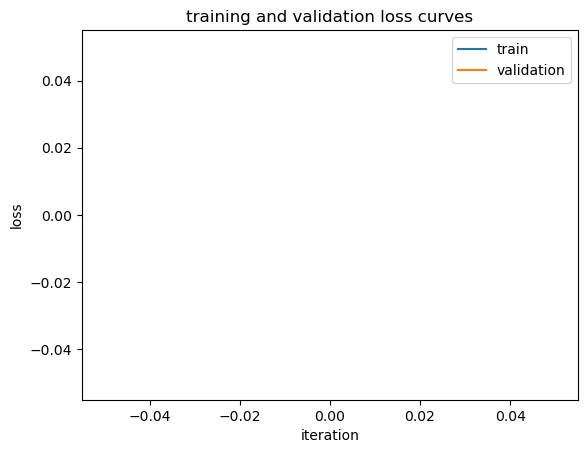

In [526]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [528]:
# plot recall_at_k curves 
# somehow not work, need to check later 

# f2 = plt.figure()
# plt.plot(iters, val_recall_at_ks, label='recall_at_k')
# plt.xlabel('iteration')
# plt.ylabel('recall_at_k')
# plt.title('recall_at_k_curves')
# plt.show()